This notebook has porpuse of showing the calculation of Hubble parameter for the GILA model, and compare it with the Standard Cosmological Model. Let's call some libraries

In [ ]:
import time
import numpy as np
from scipy.constants import c as c_light  # units of m/s
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
c_light_km = c_light / 1000 # units of km/s

In [ ]:
#Cosmological parameters 
p = 4.0  
tilde_p = 1.0 
q = 2.0  
s = 4.0  

B = [p, tilde_p, s, q]

In [ ]:
#Fix cosmological parameters (originals)
#lambda_param = 1.0
#beta_param = 1.0 
#a_0 = 1.0
#omega_m = 0.999916
#omega_r = 1.0 - omega_m
#l = 1e-27
#tilde_l = 1.0 
FIXED_EXPRESSION = False  

#Fix cosmological parameters
lambda_param = 0.0
beta_param = 1.0
a_0 = 1.0
omega_m = 0.999916
omega_r = 1.0 - omega_m
l = 1e-27
tilde_l = 1.0
FIXED_EXPRESSION = False# True 



In [ ]:
#Integration variables
y_i = 0.0
x_i = 0.0
x_f = -np.log(9.0)

z_i = 0
z_f = 3 #8

#n = 300
#h = (x_f - x_i)/(1.0 * n)
#h = (z_f - z_i)/(1.0 * n)

In [ ]:
#Runge Kutta 4 functions

def rk4_step(f, y, t, dt, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l):
    """
    Perform a single RK4 step.
    
    Parameters:
    f : function
        The function that returns dy/dt. It must be of the form f(t, y).
    y : array-like
        The current value of the dependent variable.
    t : float
        The current value of the independent variable (usually time).
    dt : float
        The step size.
        
    Returns:
    y_next : array-like
        The value of the dependent variable after the step.
    """
    k1 = f(t, y, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)
    k4 = f(t + dt, y + dt * k3, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)
    y_next = y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_next

def rk4(f, y0, t, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l):
    """
    Solve an ODE using the RK4 method.
    
    Parameters:
    f : function
        The function that returns dy/dt. It must be of the form f(t, y).
    y0 : array-like
        The initial value of the dependent variable.
    t : array-like
        The array of time points at which to solve the ODE.
        
    Returns:
    y : array-like
        The array of values of the dependent variable at each time point.
    """
    #y = np.zeros((len(t), len(y0)))
    y = np.zeros(len(t))
    y[0] = y0
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        y[i] = rk4_step(f, y[i-1], t[i-1], dt, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)
    return y

FIrstly, let's define the function that characterise our model.

In [ ]:
#Entiendo que 'x=log(a)' y 'y=H/H_0'
#Recordemos que H0 = a_0 = 1
#Haciendo cuentas concluyo que num = F(H0=1) 
#y denom = F_prime(H)/(2(H/H0)**2)

def integral_function(x,y,lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l):
    num = 1.0 + lambda_param * l**(2*p - 2) * np.exp( lambda_param * l**(2*q) ) \
            - beta_param * tilde_l**(2*tilde_p - 2) \
            * np.exp( -beta_param * tilde_l**(2*s) )

    denom = 1.0 + lambda_param * l**(2*p - 2) \
                * np.exp( (2.0 * p - 2.0) * y + lambda_param * l**(2*q) \
                * np.exp( 2.0*q*y ) ) \
                * ( p + lambda_param * q * l**(2*q) * np.exp( 2.0*q*y ) ) \
                - beta_param * tilde_l**(2*tilde_p - 2) \
                * np.exp( (2.0 * tilde_p - 2.0) * y - beta_param * tilde_l**(2*s) \
                * np.exp( 2.0*s*y ) ) \
                * ( tilde_p - beta_param * s * tilde_l**(2*s) * np.exp( 2.0*s*y ) )

    output = - 0.5 * np.exp(-3.0 * x - 2.0 * y) * a_0**(-3) \
            * num * ( 3.0 * omega_m + 4.0 * omega_r * np.exp(-x) / a_0 ) / denom
    
    if FIXED_EXPRESSION == True:
        #FIXED EXPRESSION        
        output = - 0.5 * np.exp(-3.0 * x) * a_0**(-3) \
                * num * ( 3.0 * omega_m + 4.0 * omega_r * np.exp(-x) / a_0 ) / denom
    return output


def integral_function_z(z,y,lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l):
    a = 1/(1+z)
    x = np.log(a)

    num = 1.0 + lambda_param * l**(2*p - 2) * np.exp( lambda_param * l**(2*q) ) \
            - beta_param * tilde_l**(2*tilde_p - 2) \
            * np.exp( -beta_param * tilde_l**(2*s) )

    denom = 1.0 + lambda_param * l**(2*p - 2) \
                * np.exp( (2.0 * p - 2.0) * y + lambda_param * l**(2*q) \
                * np.exp( 2.0*q*y ) ) \
                * ( p + lambda_param * q * l**(2*q) * np.exp( 2.0*q*y ) ) \
                - beta_param * tilde_l**(2*tilde_p - 2) \
                * np.exp( (2.0 * tilde_p - 2.0) * y - beta_param * tilde_l**(2*s) \
                * np.exp( 2.0*s*y ) ) \
                * ( tilde_p - beta_param * s * tilde_l**(2*s) * np.exp( 2.0*s*y ) )

    output = - 0.5 * np.exp(-3.0 * x - 2.0 * y) * a_0**(-3) \
            * num * ( 3.0 * omega_m + 4.0 * omega_r * np.exp(-x) / a_0 ) / denom

    if FIXED_EXPRESSION == True:

        #FIXED EXPRESSION    
        output = - 0.5 * np.exp(-3.0 * x) * a_0**(-3) \
                * num * ( 3.0 * omega_m + 4.0 * omega_r * np.exp(-x) / a_0 ) / denom

    return (-1/(1+z)) * output

In [ ]:
def integrator(num_z_points=int(10**5), system_equations=integral_function, y0=1,verbose=True):
 
    t1 = time.time()
            

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    xs_final = np.linspace(x_i, x_f, num_z_points)
    Hs_final = rk4(system_equations, y0, xs_final, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)


    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return xs_final, Hs_final


def integrator_z(num_z_points=int(10**5), system_equations=integral_function_z, y0=1,verbose=True):
 
    t1 = time.time()
            

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = np.linspace(z_i, z_f, num_z_points)
    Hs_final = rk4(system_equations, y0, zs_final, lambda_param, beta_param, p, tilde_p, s, q, a_0, omega_m, omega_r, l, tilde_l)


    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

The Standard Cosmological model $H(z)$ is defined by

In [ ]:
def H_LCDM(z, omega_m, H_0):
    '''
    Calculation of the Hubble parameter.
    Here we neclect the radiation (it holds 
    that \Omega_r + \Omega_m + \Omega_L = 1).
    '''
    
    omega_lambda = 1 - omega_m
    H = H_0 * np.sqrt(omega_m * (1 + z)**3 + omega_lambda)
    
    return H


def H_LCDM_log_a(log_a, omega_m, H_0):
    '''
    Calculation of the Hubble parameter.
    Here we neclect the radiation (it holds 
    that \Omega_r + \Omega_m + \Omega_L = 1).
    '''
    
    omega_lambda = 1 - omega_m - omega_r
    H = H_0 * np.sqrt(omega_m * np.exp(-3 * log_a) + omega_lambda)
    
    return H

Finally, we plot $H(z)$ for different values of the scale $\bar{L}$

Duration: 0 minutes and 8 seconds


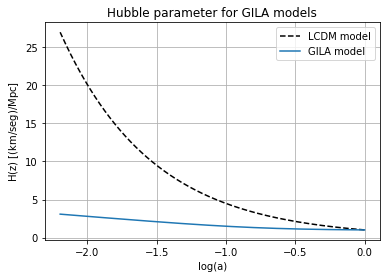

[1.         1.00000282 1.00000564 ... 3.07404361 3.0740761  3.07410859]


In [99]:
# Plot Hubble diagrams for different models
plt.figure()
plt.title('Hubble parameter for GILA models')
plt.xlabel('log(a)')
plt.ylabel(r'H(z) $\rm [(km/seg)/Mpc]$')
plt.legend(loc='best')
plt.grid(True)

H_0 = 1

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors1 = ['b--', 'g--', 'r--', 'c--', 'm--', 'y--', 'k--']

#Plot LCDM Hubble parameter
#redshift_LCDM = np.linspace(0, 3, int(10**5))
log_a_LCDM = np.linspace(x_i, x_f, int(10**5))
plt.plot(log_a_LCDM, H_LCDM_log_a(log_a_LCDM,omega_m,H_0),'--k',label='LCDM model') 


# Plot GILA Hubble function
#omega_m = omega_luisa_to_CDM(b, L_bar, H_0, omega_m_luisa) #L_bar in units of H0 (inside the function L_bar is divided by H0)
print(r'\Omega_m^LCDM$={}'.format(omega_m))
log_a, hubble_values = integrator()
plt.plot(log_a, hubble_values,label='GILA model')


plt.legend(loc='best')
plt.show()

print(hubble_values)

No handles with labels found to put in legend.


\Omega_m^LCDM$=0.999916
Duration: 0 minutes and 10 seconds


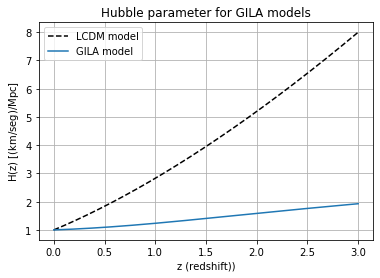

[1.         1.00000385 1.0000077  ... 1.92741962 1.92742926 1.9274389 ]


In [100]:
# Plot Hubble diagrams for different models
plt.figure()
plt.title('Hubble parameter for GILA models')
plt.xlabel('z (redshift))')
plt.ylabel(r'H(z) $\rm [(km/seg)/Mpc]$')
plt.legend(loc='best')
plt.grid(True)

H_0 = 1

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors1 = ['b--', 'g--', 'r--', 'c--', 'm--', 'y--', 'k--']

#Plot LCDM Hubble parameter
#redshift_LCDM = np.linspace(0, 3, int(10**5))
z_LCDM = np.linspace(z_i, z_f, int(10**5))
plt.plot(z_LCDM, H_LCDM(z_LCDM,omega_m,H_0),'--k',label='LCDM model') 


# Plot GILA Hubble function
#omega_m = omega_luisa_to_CDM(b, L_bar, H_0, omega_m_luisa) #L_bar in units of H0 (inside the function L_bar is divided by H0)
print(r'\Omega_m^LCDM$={}'.format(omega_m))
z_LCDM, hubble_values = integrator_z()
plt.plot(z_LCDM, hubble_values,label='GILA model')


plt.legend(loc='best')
plt.show()

print(hubble_values)